# 生成对抗网络
前面我们讲了自动编码器和变分自动编码器，不管是哪一个，都是通过计算生成图像和输入图像在每个像素点的误差来生成 loss，这一点是特别不好的，因为不同的像素点可能造成不同的视觉结果，但是可能他们的 loss 是相同的，所以通过单个像素点来得到 loss 是不准确的，这个时候我们需要一种全新的 loss 定义方式，就是通过对抗进行学习。

## GANs
这种训练方式定义了一种全新的网络结构，就是生成对抗网络，也就是 GANs。这一部分，我们会形象地介绍生成对抗网络，以及用代码进行实现，而在书中会更加详细地介绍 GANs 的数学推导。

根据这个名字就可以知道这个网络是由两部分组成的，第一部分是生成，第二部分是对抗。简单来说，就是有一个生成网络和一个判别网络，通过训练让两个网络相互竞争，生成网络来生成假的数据，对抗网络通过判别器去判别真伪，最后希望生成器生成的数据能够以假乱真。

可以用这个图来简单的看一看这两个过程

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22oma081j30k007cgll.jpg)

### Discriminator Network
首先我们来讲一下对抗过程，因为这个过程更加简单。

对抗过程简单来说就是一个判断真假的判别器，相当于一个二分类问题，我们输入一张真的图片希望判别器输出的结果是1，输入一张假的图片希望判别器输出的结果是0。这其实已经和原图片的 label 没有关系了，不管原图片到底是一个多少类别的图片，他们都统一称为真的图片，label 是 1 表示真实的；而生成的假的图片的 label 是 0 表示假的。

我们训练的过程就是希望这个判别器能够正确的判出真的图片和假的图片，这其实就是一个简单的二分类问题，对于这个问题可以用我们前面讲过的很多方法去处理，比如 logistic 回归，深层网络，卷积神经网络，循环神经网络都可以。

### Generator Network
接着我们看看生成网络如何生成一张假的图片。首先给出一个简单的高维的正态分布的噪声向量，如上图所示的 D-dimensional noise vector，这个时候我们可以通过仿射变换，也就是 xw+b 将其映射到一个更高的维度，然后将他重新排列成一个矩形，这样看着更像一张图片，接着进行一些卷积、转置卷积、池化、激活函数等进行处理，最后得到了一个与我们输入图片大小一模一样的噪音矩阵，这就是我们所说的假的图片。

这个时候我们如何去训练这个生成器呢？这就需要通过对抗学习，增大判别器判别这个结果为真的概率，通过这个步骤不断调整生成器的参数，希望生成的图片越来越像真的，而在这一步中我们不会更新判别器的参数，因为如果判别器不断被优化，可能生成器无论生成什么样的图片都无法骗过判别器。

生成器的效果可以看看下面的图示

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22s47jnfj30k005c74b.jpg)

关于生成对抗网络，出现了很多变形，比如 WGAN，LS-GAN 等等，这一节我们只使用 mnist 举一些简单的例子来说明，更复杂的网络结构可以再 github 上找到相应的实现

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.examples.tutorials.mnist.input_data as input_data

tf.set_random_seed(2017)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def deprocess_img(x):
    return (x + 1.0) / 2.0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('MNIST_data')
train_set = mnist.train
test_set = mnist.test

input_ph = tf.placeholder(tf.float32, shape=[None, 784])
inputs = tf.divide(input_ph - 0.5, 0.5)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 简单版本的生成对抗网络
通过前面我们知道生成对抗网络有两个部分构成，一个是生成网络，一个是对抗网络，我们首先写一个简单版本的网络结构，生成网络和对抗网络都是简单的多层神经网络

### 判别网络
判别网络的结构非常简单，就是一个二分类器，结构如下:
* 全连接(784 -> 256)
* leakyrelu,  $\alpha$ 是 0.2
* 全连接(256 -> 256)
* leakyrelu, $\alpha$ 是 0.2
* 全连接(256 -> 1)

其中 leakyrelu 是指 f(x) = max($\alpha$ x, x)

In [3]:
def discriminator(inputs, scope='discriminator', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.fully_connected], activation_fn=None):
            net = slim.fully_connected(inputs, 256, scope='fc1')
            net = tf.nn.leaky_relu(net, alpha=0.2, name='act1')
            net = slim.fully_connected(net, 256, scope='fc2')
            net = tf.nn.leaky_relu(net, alpha=0.2, name='act2')
            net = slim.fully_connected(net, 1, scope='fc3')
            
            return net

### 生成网络
接下来我们看看生成网络，生成网络的结构也很简单，就是根据一个随机噪声生成一个和数据维度一样的张量，结构如下：
* 全连接(噪音维度 -> 1024)
* relu
* 全连接(1024 -> 1024)
* relu
* 全连接(1024 -> 784)
* tanh 将数据裁剪到 -1 ~ 1 之间

In [4]:
def generator(noise, scope='generator', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
            net = slim.fully_connected(noise, 1024, scope='fc1')
            net = slim.fully_connected(net, 1024, scope='fc2')
            net = slim.fully_connected(net, 784, activation_fn=tf.tanh, scope='fc3')
            
            return net

接下来我们需要定义生成对抗网络的 loss，通过前面的讲解我们知道，对于对抗网络，相当于二分类问题，将真的判别为真的，假的判别为假的，作为辅助，可以参考一下论文中公式

$$ \ell_D = \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

而对于生成网络，需要去骗过对抗网络，也就是将假的也判断为真的，作为辅助，可以参考一下论文中公式

$$\ell_G  =  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

如果你还记得前面的二分类 loss，那么你就会发现上面这两个公式就是二分类 loss

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

In [5]:
batch_size = tf.shape(input_ph)[0]
true_labels = tf.ones((batch_size, 1), dtype=tf.int64, name='true_labels')
fake_labels = tf.zeros((batch_size, 1), dtype=tf.int64, name='fake_labels')

In [6]:
def discriminator_loss(logits_real, logits_fake, scope='D_loss'): # 判别网络的`loss`
    with tf.variable_scope(scope):
        # 在`tensorflow`中我们使用`log_loss`, 并且需要将判别网络的输出
        # 用`sigmoid`函数转化为概率
        loss = tf.losses.log_loss(true_labels, tf.sigmoid(logits_real)) + tf.losses.log_loss(fake_labels, tf.sigmoid(logits_fake))
        return loss

In [7]:
def generator_loss(logits_fake, scope='G_loss'): # 生成网络的`loss`
    with tf.variable_scope(scope):
        loss = tf.losses.log_loss(true_labels, tf.sigmoid(logits_fake))
    return loss

然后我们采用从$[-1, 1]$均匀随机分布产生的96维随机向量作为生成网络的输入

In [8]:
noise_dim = 96
sample_noise = tf.random_uniform([batch_size, noise_dim], dtype=tf.float32, minval=-1.0, maxval=1.0, name='sample_noise')
inputs_fake = generator(sample_noise)

In [9]:
logits_real = discriminator(inputs) # 获得真实数据的分数
logits_fake = discriminator(inputs_fake, reuse=True) # 获得生成数据的分数

In [10]:
d_total_error = discriminator_loss(logits_real, logits_fake) # 判别网络`loss`
g_total_error = generator_loss(logits_fake) # 生成网络`loss`

我们使用`adam`来训练, 学习率是`3e-4`, `beta1`是`0.5`, `beta2`是`0.999`

In [11]:
opt = tf.train.AdamOptimizer(3e-4, beta1=0.5, beta2=0.999)

In [12]:
# 获得判别网络的可训练参数
discriminator_params = tf.trainable_variables('discriminator')

# 构造判别训练`op`
train_discriminator = opt.minimize(d_total_error, var_list=discriminator_params)

In [13]:
# 获得生成网络可训练参数
generator_params = tf.trainable_variables('generator')

# 构造生成训练'op'
with tf.control_dependencies([train_discriminator]):
    train_generator = opt.minimize(g_total_error, var_list=generator_params)

In [14]:
sess = tf.Session()

Iter: 0, D: 1.6498, G: 0.7098


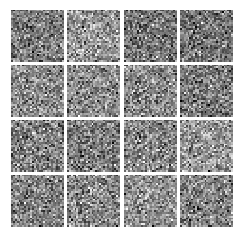


Iter: 250, D: 1.4771, G: 0.5492


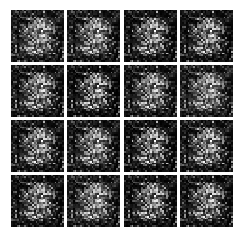


Iter: 500, D: 1.2708, G: 0.5837


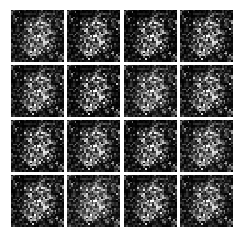


Iter: 750, D: 1.0747, G: 0.6536


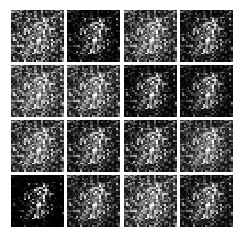


Iter: 1000, D: 0.7560, G: 1.2883


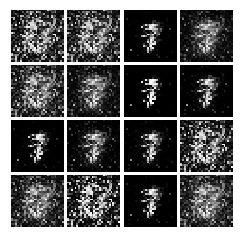


Iter: 1250, D: 0.6093, G: 1.3977


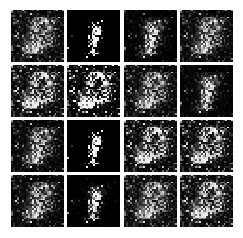


Iter: 1500, D: 0.5689, G: 1.1373


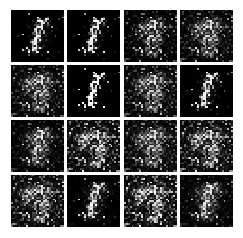


Iter: 1750, D: 1.0633, G: 1.0773


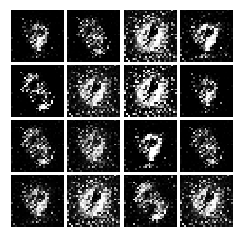


Iter: 2000, D: 0.7386, G: 1.6569


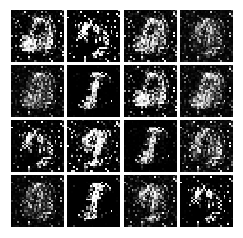


Iter: 2250, D: 1.3382, G: 0.4293


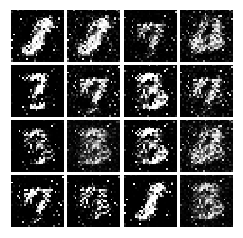


Iter: 2500, D: 0.9811, G: 0.9917


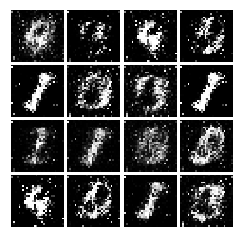


Iter: 2750, D: 0.8096, G: 0.9722


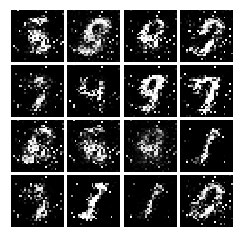


Iter: 3000, D: 1.0125, G: 1.4414


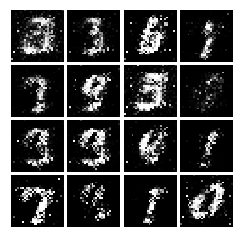


Iter: 3250, D: 1.1217, G: 1.0526


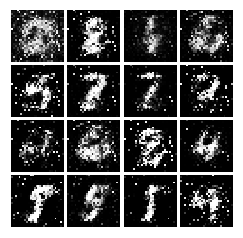


Iter: 3500, D: 1.1426, G: 0.7640


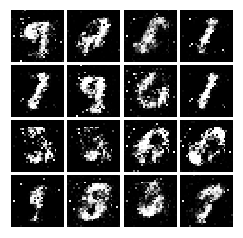


Iter: 3750, D: 1.0282, G: 1.1594


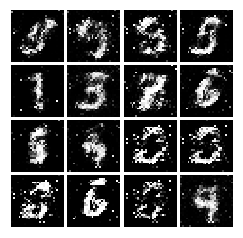


Iter: 4000, D: 1.0227, G: 1.3157


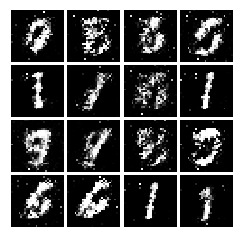


Iter: 4250, D: 1.2183, G: 0.9640


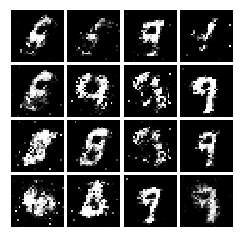

In [15]:
sess.run(tf.global_variables_initializer())

iter_count = 0
show_every = 250
for e in range(10):
    num_examples = 0
    while num_examples < train_set.num_examples:
        if num_examples + 128 < train_set.num_examples:
            batch = 128
        else:
            batch = train_set.num_examples - num_examples
        num_examples += batch
        train_imgs, _ = train_set.next_batch(batch)
        loss_d, loss_g, fake_imgs, _ = sess.run([d_total_error, g_total_error, inputs_fake, train_generator], feed_dict={input_ph: train_imgs})
        
        if (iter_count % show_every == 0):
            print('Iter: {}, D: {:.4f}, G: {:.4f}'.format(iter_count, loss_d, loss_g))
            imgs_numpy = deprocess_img(fake_imgs)
            show_images(imgs_numpy[:16])
            plt.show()
            print()
        iter_count += 1

我们已经完成了一个简单的生成对抗网络，是不是非常容易呢。但是可以看到效果并不是特别好，生成的数字也不是特别完整，因为我们仅仅使用了简单的多层全连接网络。

除了这种最基本的生成对抗网络之外，还有很多生成对抗网络的变式，有结构上的变式，也有 loss 上的变式，我们先讲一讲其中一种在 loss 上的变式，Least Squares GAN

## Least Squares GAN
[Least Squares GAN](https://arxiv.org/abs/1611.04076) 比最原始的 GANs 的 loss 更加稳定，通过名字我们也能够看出这种 GAN 是通过最小平方误差来进行估计，而不是通过二分类的损失函数，下面我们看看 loss 的计算公式

$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

可以看到 Least Squares GAN 通过最小二乘代替了二分类的 loss，下面我们定义一下 loss 函数

In [16]:
def ls_discriminator_loss(logits_real, logits_fake, scope='LS_D_Loss'):
    with tf.variable_scope(scope):
        loss = 0.5 * tf.reduce_mean(tf.square(logits_real - 1)) + 0.5 * tf.reduce_mean(tf.square(logits_fake))
    return loss

def ls_generator_loss(logits_fake, scope='LS_G_Loss'):
    with tf.variable_scope(scope):
        loss = 0.5 * tf.reduce_mean(tf.square(logits_fake - 1))
    return loss

In [17]:
# 重新定义`loss`
ls_d_total_error = ls_discriminator_loss(logits_real, logits_fake)
ls_g_total_error = ls_generator_loss(logits_fake)

In [18]:
train_ls_d = opt.minimize(ls_d_total_error, var_list=discriminator_params)

with tf.control_dependencies([train_ls_d]):
    train_ls_g = opt.minimize(ls_g_total_error, var_list=generator_params)

Iter: 0, D: 0.8376, G: 0.4607


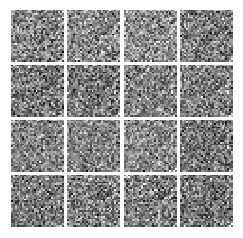


Iter: 250, D: 0.2469, G: 0.0564


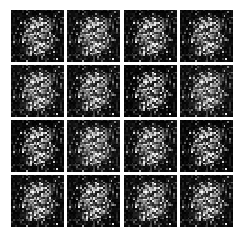


Iter: 500, D: 0.1832, G: 0.1357


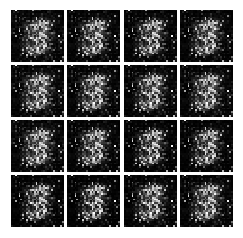


Iter: 750, D: 0.0587, G: 0.3044


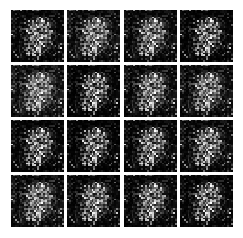


Iter: 1000, D: 0.0794, G: 0.4929


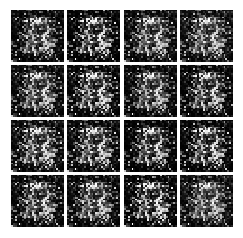


Iter: 1250, D: 0.0271, G: 0.3841


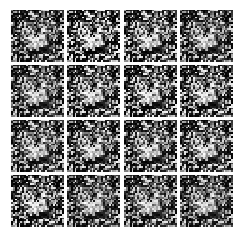


Iter: 1500, D: 0.0641, G: 0.4002


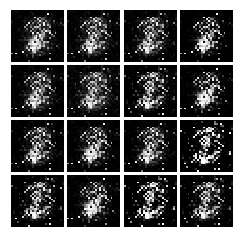


Iter: 1750, D: 0.1151, G: 0.6228


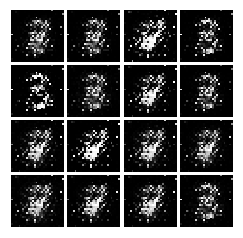


Iter: 2000, D: 0.0947, G: 0.2277


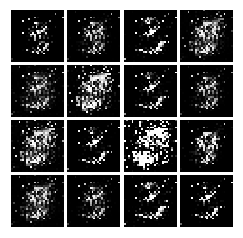


Iter: 2250, D: 0.0566, G: 0.5168


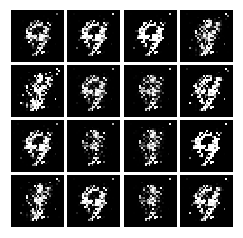


Iter: 2500, D: 0.0573, G: 0.3276


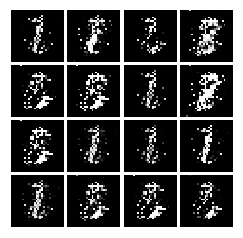


Iter: 2750, D: 0.0319, G: 0.4385


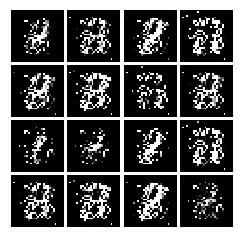


Iter: 3000, D: 0.0397, G: 0.5059


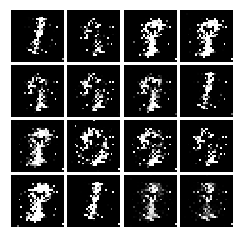


Iter: 3250, D: 0.0465, G: 0.3456


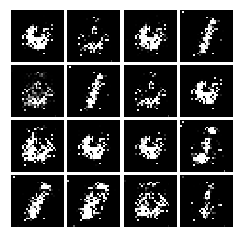


Iter: 3500, D: 0.0460, G: 0.4156


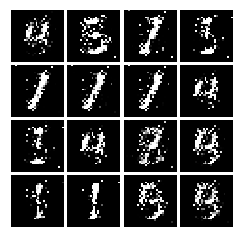


Iter: 3750, D: 0.0405, G: 0.4712


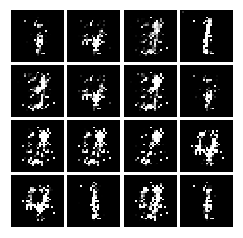


Iter: 4000, D: 0.0345, G: 0.4440


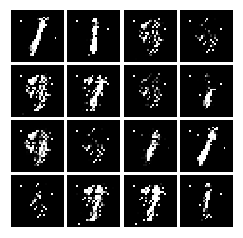


Iter: 4250, D: 0.0915, G: 0.6110


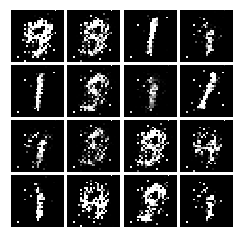

In [19]:
sess.run(tf.global_variables_initializer())

iter_count = 0
show_every = 250
for e in range(10):
    num_examples = 0
    while num_examples < train_set.num_examples:
        if num_examples + 128 < train_set.num_examples:
            batch = 128
        else:
            batch = train_set.num_examples - num_examples
        num_examples += batch
        train_imgs, _ = train_set.next_batch(batch)
        loss_d, loss_g, fake_imgs, _ = sess.run([ls_d_total_error, ls_g_total_error, inputs_fake, train_ls_g], feed_dict={input_ph: train_imgs})
        
        if (iter_count % show_every == 0):
            print('Iter: {}, D: {:.4f}, G: {:.4f}'.format(iter_count, loss_d, loss_g))
            imgs_numpy = deprocess_img(fake_imgs)
            show_images(imgs_numpy[:16])
            plt.show()
            print()
        iter_count += 1

上面我们讲了 最基本的 GAN 和 least squares GAN，最后我们讲一讲使用卷积网络的 GAN，叫做深度卷积生成对抗网络

## Deep Convolutional GANs
深度卷积生成对抗网络特别简单，就是将生成网络和对抗网络都改成了卷积网络的形式，下面我们来实现一下

### 卷积判别网络
卷积判别网络就是一个一般的卷积网络，结构如下

* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [20]:
def dc_discriminator(inputs, scope='dc_discriminator', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.conv2d, slim.fully_connected], activation_fn=None):
            net = slim.conv2d(inputs, 32, 5, stride=1, scope='conv1')
            net = tf.nn.leaky_relu(net, alpha=0.2, name='act1')
            net = slim.max_pool2d(net, 2, stride=2, scope='maxpool1')
            net = slim.conv2d(net, 64, 5, stride=1, scope='conv2')
            net = tf.nn.leaky_relu(net, alpha=0.2, name='act2')
            net = slim.max_pool2d(net, 2, stride=2, scope='maxpool2')
            net = slim.flatten(net, scope='flatten')
            net = slim.fully_connected(net, 1024, scope='fc3')
            net = tf.nn.leaky_relu(net, alpha=0.01, name='act3')
            net = slim.fully_connected(net, 1, scope='fc4')
            
            return net

### 卷积生成网络
卷积生成网络需要将一个低维的噪声向量变成一个图片数据，结构如下

* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Reshape into Image Tensor
* 64 conv2d^T filters of 4x4, stride 2, padding 1, ReLU
* BatchNorm
* 1 conv2d^T filter of 4x4, stride 2, padding 1, TanH

In [21]:
def dc_generator(inputs, scope='dc_generator', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose], activation_fn=None):
            net = slim.fully_connected(inputs, 1024, scope='fc1')
            net = tf.nn.relu(net, name='act1')
            net = slim.batch_norm(net, scope='bn1')
            net = slim.fully_connected(net, 7 * 7 * 128, scope='fc2')
            net = tf.nn.relu(net, name='act2')
            net = slim.batch_norm(net, scope='bn2')
            net = tf.reshape(net, (-1, 7, 7, 128))
            net = slim.conv2d_transpose(net, 64, 4, stride=2, scope='convT3')
            net = tf.nn.relu(net, name='act3')
            net = slim.batch_norm(net, scope='bn3')
            net = slim.conv2d_transpose(net, 1, 4, stride=2, scope='convT4')
            net = tf.tanh(net, name='tanh')
            
            return net

In [22]:
dc_inputs = tf.reshape(inputs, (-1, 28, 28, 1))
logits_real = dc_discriminator(dc_inputs)
inputs_fake = dc_generator(sample_noise)
logits_fake = dc_discriminator(inputs_fake, reuse=True)

In [23]:
d_total_error = discriminator_loss(logits_real, logits_fake)
g_total_error = generator_loss(logits_fake)

In [24]:
dc_discriminator_params = tf.trainable_variables('dc_discriminator')
dc_generator_params = tf.trainable_variables('dc_generator')

In [25]:
train_discriminator = opt.minimize(d_total_error, var_list=dc_discriminator_params)

with tf.control_dependencies([train_discriminator]):
    train_generator = opt.minimize(g_total_error, var_list=dc_generator_params)

Iter: 0, D: 1.3797, G: 0.7237


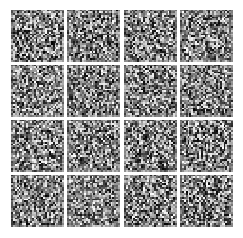


Iter: 250, D: 0.6003, G: 2.1582


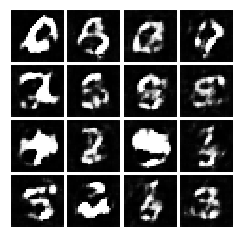


Iter: 500, D: 0.8546, G: 1.5041


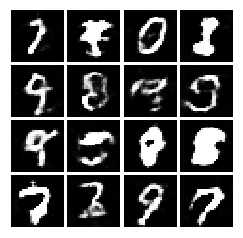


Iter: 750, D: 0.8505, G: 1.0628


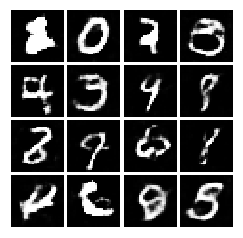


Iter: 1000, D: 1.0081, G: 1.3698


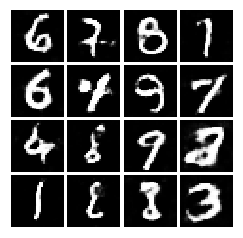


Iter: 1250, D: 1.0435, G: 1.1489


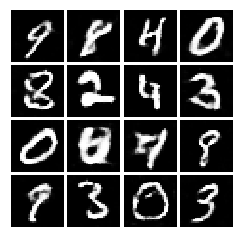


Iter: 1500, D: 1.1032, G: 1.6931


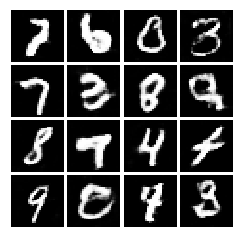


Iter: 1750, D: 1.2585, G: 0.5730


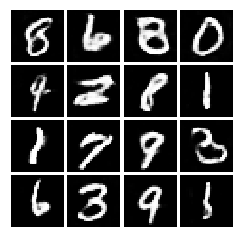


Iter: 2000, D: 1.0420, G: 1.0065


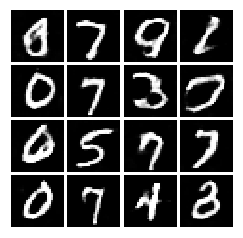

In [26]:
sess.run(tf.global_variables_initializer())

iter_count = 0
show_every = 250
for e in range(5):
    num_examples = 0
    while num_examples < train_set.num_examples:
        if num_examples + 128 < train_set.num_examples:
            batch = 128
        else:
            batch = train_set.num_examples - num_examples
        num_examples += batch
        train_imgs, _ = train_set.next_batch(batch)
        loss_d, loss_g, fake_imgs, _ = sess.run([d_total_error, g_total_error, inputs_fake, train_generator], feed_dict={input_ph: train_imgs})
        
        if (iter_count % show_every == 0):
            print('Iter: {}, D: {:.4f}, G: {:.4f}'.format(iter_count, loss_d, loss_g))
            imgs_numpy = deprocess_img(fake_imgs)
            show_images(imgs_numpy[:16])
            plt.show()
            print()
        iter_count += 1

可以看到，通过 DCGANs 能够得到更加清楚的结果